In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal, mindelo, find_ec_lon, vertical_preview, to_kml
import pandas as pd

In [21]:
# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 21, 12, 0, 0)

flight_time = datetime(2024, 8, 25, 12, 0, 0)
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print(
    f"Initalization date of IFS forecast: {issued_time}\n"
    f"Flight date: {flight_time:%Y-%m-%d}\n"
    f"Flight index: {flight_index}"
)

Initalization date of IFS forecast: 2024-08-21 12:00:00
Flight date: 2024-08-25
Flight index: HALO-20240825a


In [22]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [23]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(datetime = issued_time).to_dask().pipe(egh.attach_coords)

In [24]:
# Load ec satellite track for 
ec_track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-21", kind="PRE").get_track_for_day(f"{flight_time:%Y-%m-%d}")
ec_track = ec_track.sel(time=slice(f"{flight_time:%Y-%m-%d} 06:00", None))
ec_lons, ec_lats = ec_track.lon.values, ec_track.lat.values

In [25]:
def ec_time_at_lat(ec_track, lat):
    e = np.datetime64("2024-08-01")
    s = np.timedelta64(1, "ns")
    return (((ec_track.swap_dims({"time":"lat"}).time - e) / s).interp(lat=lat) * s + e)

**Waypoint definitions**

In [26]:
# Mass flux circle radius (m)
radius = 130e3
atr_radius = 70e3

In [27]:
# Setting region (Cabo Verde vs. Barbados)
band = "east"
airport = sal if band == "east" else bco

In [28]:
# Latitudes where we enter and leave the ec track (visually estimated)
lat_ec_north_out = 16.0
lat_ec_north_in = 12.0
lat_ec_south = 2.5

In [29]:
# ITCZ edges visually estimated from iwv contours
lat_c_south = 4.0
lat_c_north = 10.0

In [30]:
# Setting lat/lon coordinates

# Points where we get on ec track
north_ec_in = LatLon(lat_ec_north_in, find_ec_lon(lat_ec_north_in, ec_lons, ec_lats), label = "north_ec_in")
north_ec_out = LatLon(lat_ec_north_out, find_ec_lon(lat_ec_north_out, ec_lons, ec_lats), label = "north_ec_out")
south_ec = LatLon(lat_ec_south, find_ec_lon(lat_ec_south, ec_lons, ec_lats), label = "south_ec")

# Intersection of ITCZ edges with ec track
c_north = LatLon(lat_c_north, find_ec_lon(lat_c_north, ec_lons, ec_lats), label = "c_north")
c_south = LatLon(lat_c_south, find_ec_lon(lat_c_south, ec_lons, ec_lats), label = "c_south")

# Center of middle circle
c_mid = c_south.towards(c_north).assign(label = "c_mid")

# EarthCARE underpass
ec_under = c_north.towards(north_ec_out).assign(label = "ec_under")

# ATR circle
atr_circ = LatLon(17.433, -23.5, label = "atr")

# Define flight track, can be split into different legs
waypoints = [
     airport.assign(time='2024-08-25T09:30:00Z'), 
     north_ec_in.assign(fl=400),
     c_north.assign(fl=400),
     c_mid.assign(fl=400),
     c_south.assign(fl=400),
     south_ec.assign(fl=430),
     IntoCircle(c_south.assign(fl=430), radius, 360),  
     IntoCircle(c_mid.assign(fl=430), radius, 360), 
     IntoCircle(c_north.assign(fl=450), radius, 360),
     ec_under.assign(fl=450),
     north_ec_out.assign(fl=450),
     mindelo.assign(fl=450),
     IntoCircle(atr_circ.assign(fl=350), atr_radius, 360),
     airport
] 

path = fp.expand_path(waypoints, dx=10e3)

In [31]:
ec_time_at_lat(ec_track, ec_under.lat).values

np.datetime64('2024-08-25T16:11:34.286797205')

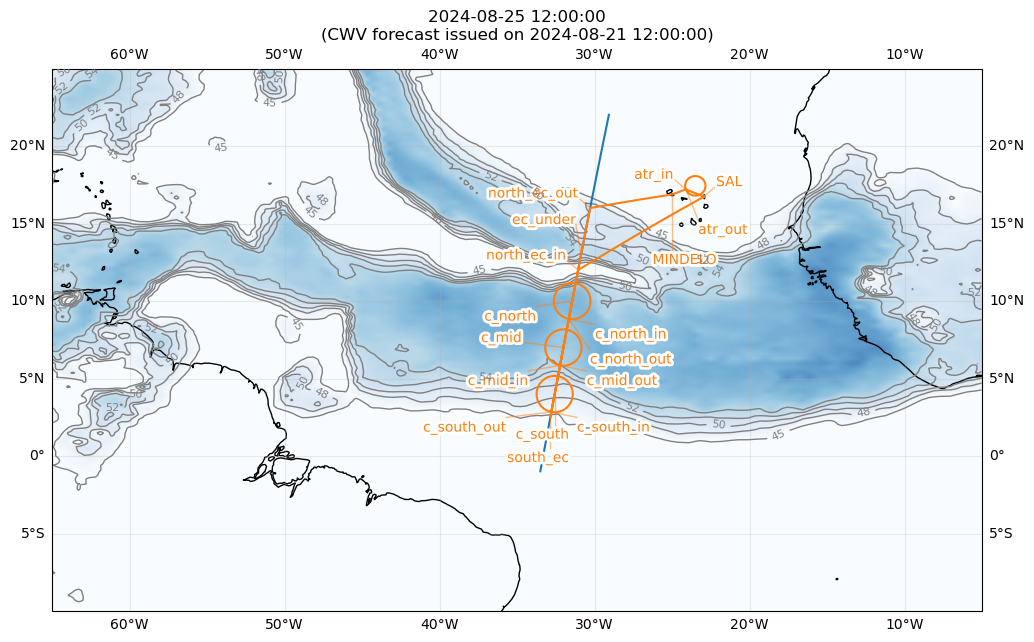

In [32]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [45.0, 48.0, 50.0, 52.0, 54.0])
plt.title(f"{flight_time}\n(CWV forecast issued on {issued_time})")

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

crew:
  - name: Julia Windmiller
    job: PI
  - name: Tanja Bodenbach
    job: WALES
  - name: Jakob Deutloff
    job: HAMP
  - name: Theresa Mieslinger
    job: Dropsondes
  - name: Kevin Wolf
    job: Smart/VELOX
  - name: tbd
    job: SpecMACS
  - name: Suelly Katiza
    job: Scientist
  - name: tbd
    job: Ground contact

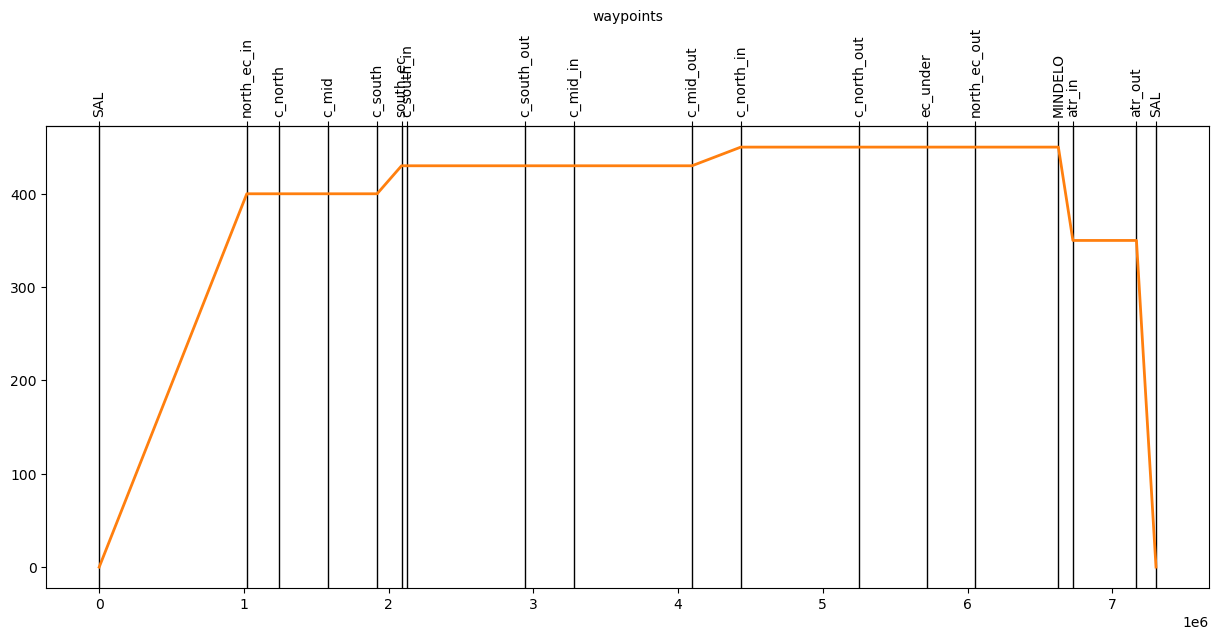

In [33]:
vertical_preview(waypoints)

In [34]:
path.isel(distance = path.waypoint_indices).to_dataframe().set_index("waypoint_labels")

,waypoint_indices,distance,lon,lat,fl,speed,duration,time
waypoint_labels,,,,,,,,
SAL,0,0.000000e+00,-22.943974,16.734488,0.0,180.724333,0 days 00:00:00,2024-08-25 09:30:00.000000000
north_ec_in,102,1.019982e+06,-31.061255,12.000000,400.0,233.146222,0 days 01:27:00.708699826,2024-08-25 10:57:00.708699826
c_north,125,1.245113e+06,-31.443103,10.000000,400.0,233.146222,0 days 01:43:06.329115329,2024-08-25 11:13:06.329115329
c_mid,159,1.582697e+06,-32.011312,7.000529,400.0,233.146222,0 days 02:07:14.279645678,2024-08-25 11:37:14.279645678
c_south,193,1.920281e+06,-32.572303,4.000000,400.0,233.146222,0 days 02:31:22.230176027,2024-08-25 12:01:22.230176027
south_ec,210,2.089041e+06,-32.852234,2.500000,430.0,236.541556,0 days 02:43:20.687766518,2024-08-25 12:13:20.687766518
c_south_in,214,2.127800e+06,-32.788011,2.844519,430.0,236.541556,0 days 02:46:04.546223538,2024-08-25 12:16:04.546223538
c_south_out,301,2.942961e+06,-32.788011,2.844519,430.0,236.541556,0 days 03:43:30.711279705,2024-08-25 13:13:30.711279705
c_mid_in,335,3.280546e+06,-32.228284,5.845207,430.0,236.541556,0 days 04:07:17.877700895,2024-08-25 13:37:17.877700895


In [35]:
with open(f"{flight_index}.kml", "w") as f:
    f.write(to_kml(path))

In [36]:
points_fx_DM = []
points_fx_DMmm = []

for point in waypoints:
    
    if isinstance(point, IntoCircle):
        point = point.center
        
    points_fx_DM.append(point.format_1min())
    points_fx_DMmm.append(point.format_pilot())

output_file = f"waypoints_{flight_index}.txt"

with open(output_file, "w") as file:
    file.write("DM\n")
    file.write(" ".join(points_fx_DM) + "\n")
    file.write("DMmm\n")
    file.write(" ".join(points_fx_DMmm) + "\n")